## Imports 📦

In [1]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

## Load Data 💿

In [3]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [4]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [5]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()
en_comment_with_emoji = en_df['text'].to_list()
es_comment_with_emoji = es_df['text'].to_list()

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def filter_comments(comment_list, stop_words):
    filtered_comments = []

    for comment in comment_list:
        # remove word starts with @
        comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # remove stopwords
        words = nltk.word_tokenize(comment)
        filtered_comment = [word for word in words if word.lower() not in stop_words]
        filtered_comment = ' '.join(filtered_comment)
        filtered_comment = comment
        filtered_comments.append(filtered_comment)
    return filtered_comments

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
en_filtered_comments = filter_comments(en_comment, en_stop_words)
es_filtered_comments = filter_comments(es_comment, es_stop_words)
en_with_emoji_filtered_comments = filter_comments(en_comment_with_emoji, en_stop_words)
es_with_emoji_filtered_comments = filter_comments(es_comment_with_emoji, es_stop_words)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [8]:
pip install laserembeddings

Note: you may need to restart the kernel to use updated packages.


In [9]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')
en_array = laser.embed_sentences(en_with_emoji_filtered_comments, lang='en')
es_array = laser.embed_sentences(es_with_emoji_filtered_comments, lang='es')

In [10]:
en_text_array.shape

(280, 1024)

## Emoji Embeddings using Emoji2Vec

In [11]:
from gensim.models import KeyedVectors

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

def emoji_embedding(df):
    emoji_list_list = df['emoji list'].to_list()

    # Initialize a list to store emoji embeddings
    emoji_embedding = []

    for emoji_list in emoji_list_list:
        emoji_list_embedding = []
        for emoji in emoji_list:
            try:
                emoji_list_embedding.append(emoji_model[emoji])
                
            except KeyError:
                pass

            # if len(emoji_list_embedding) != 0:
            # emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
        emoji_embedding.append(emoji_list_embedding)
    
    # average
    res = []
    for embeddings in emoji_embedding:
        average_embedding = np.mean(embeddings, axis=0)
        # padded arrays with zero emojis with a length 300 array filled with zeros
        if average_embedding is None or np.isnan(average_embedding).all():
            res.append(np.zeros(300))
        else:
            res.append(average_embedding)
    
    return np.array(res)

# en_max_size = max(len(arr) for arr in en_emoji_embedding)
# en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
# en_emoji_array = np.vstack(en_padded_arrays)

In [12]:
en_emoji_array = emoji_embedding(en_df)
es_emoji_array = emoji_embedding(es_df)

In [13]:
es_emoji_array.shape

(280, 300)

## Concatenate the text embeddings and emoji embeddings 

In [14]:
# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

In [15]:
en_embeddings.shape

(280, 1324)

## Variable names 📇
- en_text_array: LASER embeddings on text only (shape:280x1024)
- en_emoji_array: emoji2vec embeddings on emoji only (shape: 280x300)
- en_embeddings: concatenate en_text_array and en_emoji_array (shape: 280, 1324)
- en_array: LASER embeddings on text+emoji (shape: 280x1024)
- (replace en by es to get result from Spanish dataset)

## Hierarchical Clustering 🪜

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_samples

def apply_hierarchical_clustering(lang_embeddings, lang_df):
    # method = 'single', 'complete', 'average' don't cluster well
    # ward is best for 
    linkage_matrix = linkage(lang_embeddings, method='ward')
    
    # Plotting dendrogram
    plt.figure(figsize=(24, 16))
    dendrogram(linkage_matrix, labels=lang_df['text'].tolist(), color_threshold=3, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Comments')
    plt.ylabel('Distance')
    plt.show()

    # can try different thresholds and criterion
    cluster_labels = fcluster(linkage_matrix, t=3, criterion='distance')

    silhouette_scores = silhouette_samples(lang_embeddings, cluster_labels)

    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "cluster": cluster_labels,
        "silhouette_score": silhouette_scores
    })

    cluster_mean_silhouette = df_clusters.groupby('cluster')['silhouette_score'].mean().reset_index()
    df_clusters = df_clusters.merge(cluster_mean_silhouette, on='cluster', suffixes=('', '_mean'))
    # df_clusters = df_clusters.sort_values(by='silhouette_score_mean', ascending=False).drop('silhouette_score_mean', axis=1)

    return df_clusters, cluster_mean_silhouette, cluster_labels

In [90]:
from sklearn.decomposition import PCA

# def visualize_clusters(embeddings, cluster_labels):
    
#     pca = PCA(n_components=2)
#     embeddings_pca = pca.fit_transform(embeddings)

#     unique_labels = {label: idx for idx, label in enumerate(set(cluster_labels))}

#     numeric_cluster_labels = np.array([unique_labels[label] for label in cluster_labels])

#     plt.figure(figsize=(12, 8))
#     scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=numeric_cluster_labels, cmap='viridis', alpha=0.5)
#     plt.title('Cluster Visualization')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')

#     legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label+1}') for label in unique_labels.values()]
#     plt.legend(handles=legend_labels, title='Clusters')

#     plt.show()
from sklearn.manifold import TSNE
def visualize_clusters_tsne(embeddings, cluster_labels):
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title('Cluster Visualization - t-SNE Scatter Plot')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

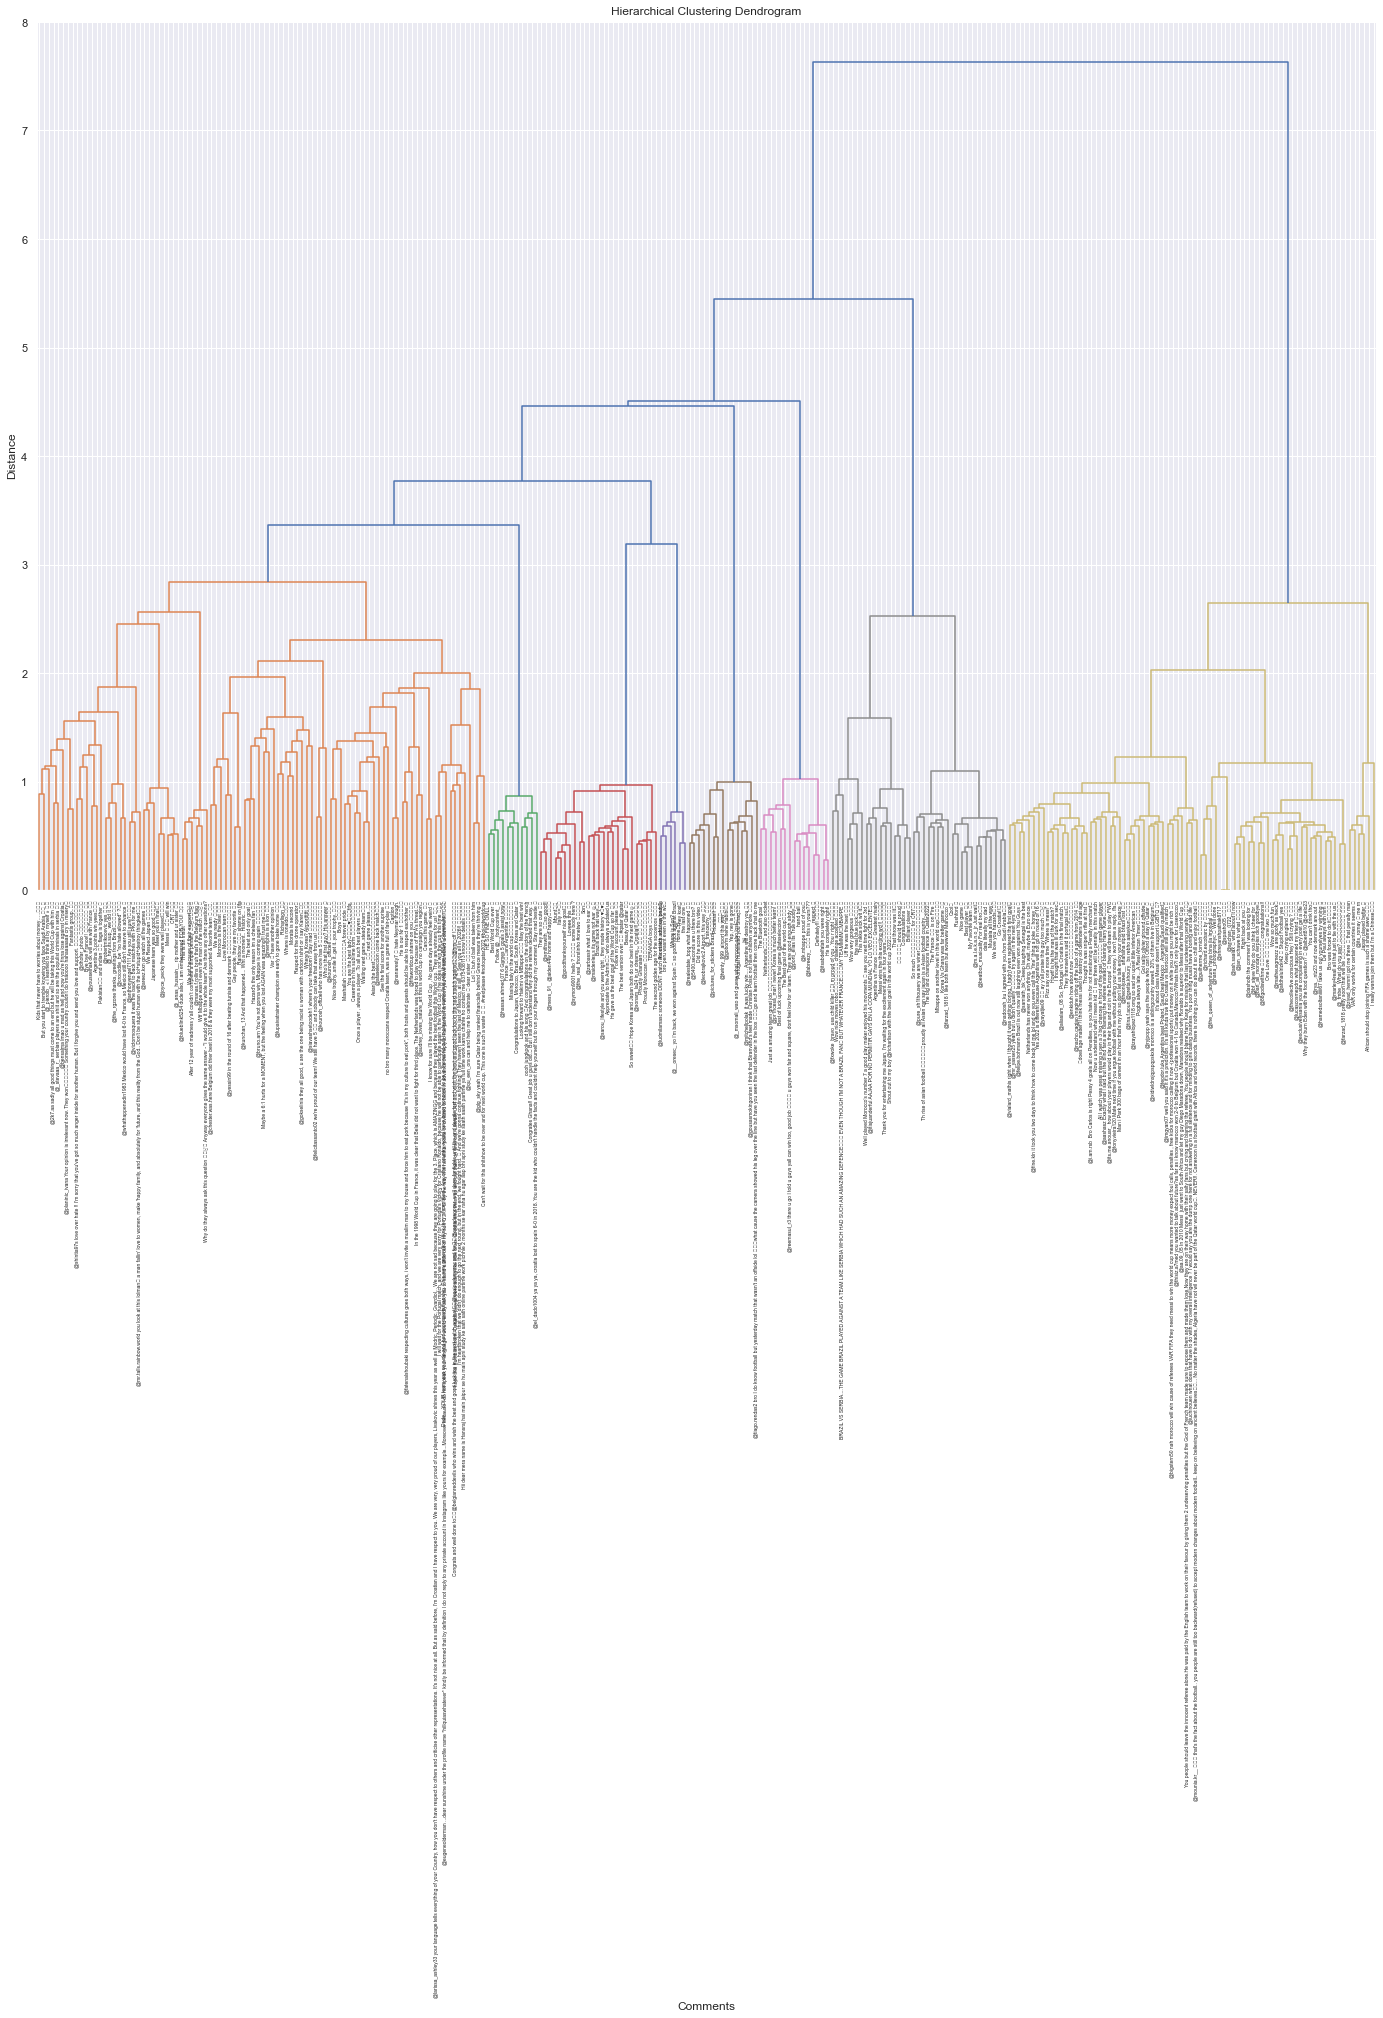

In [50]:
# Perform hierarchical clustering
en_linkage_matrix, en_mean_silhouette, en_cluster_labels = apply_hierarchical_clustering(en_embeddings, en_df)

## Cluster Labels: 😂, 🔥, 👏, 🤣, 💀, ❤️, 😍, Others

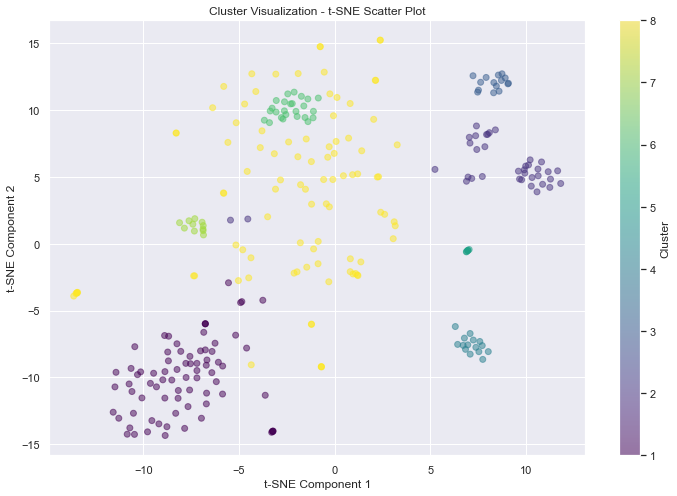

In [92]:
# Visualize clusters
visualize_clusters_tsne(en_embeddings, en_cluster_labels)

In [47]:
en_linkage_matrix

,text,cluster,silhouette_score
279,They kost💀,5,0.496161
278,@ludmilamasc someone DIDNT watch the match. sh...,5,0.512258
277,bro peru wasnt even in the wc💀,5,0.509701
276,"@__oresec_ yo I’m back, we won against Spain 💀...",5,0.468551
275,All out lets add new people\n\nWhere is Son?\n...,5,0.501797
...,...,...,...
162,@lupaivatrainer champion are early to gone bak...,8,-0.237944
163,Caption 💯,8,-0.123070
164,Mashallah 🙌❤️🇲🇦🇲🇦🇲🇦A forever pride 👏💪,8,-0.157364
165,Respect for the drone operator🛐,8,-0.176191


In [48]:
en_mean_silhouette

,cluster,silhouette_score
0,1,0.346112
1,2,0.224781
2,3,0.476288
3,4,0.417821
4,5,0.498986
5,6,0.485666
6,7,0.422899
7,8,-0.124502


In [74]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 8]['text'].tolist()

['We are ready 💛💙❤️',
 "Can't wait for this shitshow to be over and for next world cup. This one is such a waste 🗑 🙄. #nextplease #notoqatar2022 #boicotworldcup",
 'You are the best lady😻🤩🙏👏♥️⚽🤠fifa.',
 '@fatenalshoubaki respecting cultures goes both ways, i won\'t invite a muslim man to my house and force him to eat pork because "it\'s in my culture to eat pork", both hosts and guests should be able to respect eachother 👍',
 '👏😄 next game please..⚽🏃',
 '@glg_sky yeah I’m sure Qatar being ranked financially behind Greece means they’re thriving 🙄',
 'Fantastis group..✌😄',
 'Nice trophy..smile it..get it..your trophy..🏆✌😄',
 'Rainbow 🌈🌈🌈 shame on fifa',
 'Waiting next game..steady team⚽💥🏃',
 '@dhofar_photo 🏳️\u200d⚧️☪️🏳️\u200d🌈',
 'He is our Nr 1 🇨🇭👍👍🇨🇭',
 'no bro many moroccans respect Croatia team, was a game full of fair-play 👌🏽',
 'Congrats and well done to🇧🇪@belgianreddevils who wins and wish the best and good luck too in the next match against🇲🇦@equipedumaroc and for🇨🇦@canadasoccer

In [40]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 5]['text'].tolist()

['They kost💀',
 '@ludmilamasc someone DIDNT watch the match. shut up bruh💀.',
 'bro peru wasnt even in the wc💀',
 '@__oresec_ yo I’m back, we won against Spain 💀 so good luck against Brazil',
 'All out lets add new people\n\nWhere is Son?\nHome💀💀',
 'the last one 💀']

In [22]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 6]['text'].tolist()

['Italy >>❤️',
 'Proudly Ghanaian 🇬🇭 🇬🇭 🇬🇭 🇬🇭 🇬🇭 ❤️',
 'Follow m’y account please ❤️',
 '@maidenles.s its game not war ☺️',
 'Mount❤️',
 '@smithswith_ ❤️so good!!',
 'Beauty of Qatar ❤️',
 '@the_real_thorstinho #onetwo 🤭🤭🤭🤭🤭',
 'The best version ever ❤️ #qatar @qatar',
 '@goodthanksyourself nice goal❤️',
 '@zarbassir what I love to ear ❤️',
 'He gave us the best goal of the World Cup so far ❤️',
 'The second golden age for the socceroos 🇦🇺🟡🟢',
 'Loveee this ❤️',
 'Son🥺',
 'They are so cute \U0001f979\U0001f979',
 '@sarou_lifestyle and you were right , they made history ♥️♥️',
 'Appreciate to the Admin❤️ who always updated us',
 'Proudly Moroccan 🇲🇦🇲🇦🇲🇦🇲🇦❤️❤️❤️❤️',
 '@mess_91_ @aiden44w home and happy🥳🥳🤌🏻',
 '@symon9001 hello ? 🤟🏽🇦🇷 some body here ?',
 'Brazils back that way⬅️',
 'TERANGA boys 🇸🇳🇸🇳❤️',
 '@sonam_la24 in ur dreams... Croatia!!!🇭🇷❤️✌️',
 'So sweet❤️ Hope Korea and Japan both do our best in the next game☺️']

In [76]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 2]['text'].tolist()

['@itisjuanderful AAJAA POR NO PERMITIR GAYS EN LA COPA MUNDIAL YO LO VEO EXCELENTE👏🔥',
 'This nikka sick wit it🔥😂',
 'We love you hazards🔥🔥🔥',
 'The France 🇫🇷 is on Fire 🔥',
 'Wow nice moves robo😍😍😍😍😍😍😍😍 challenge accepted 🔥🔥🔥🔥',
 'dats literally my dad 🔥',
 'Best player 🔥🔥',
 '@pure_sh1thousery we are winer❤️❤️🔥🇮🇷🇮🇷🇮🇷🇮🇷',
 'Brilliant player 👏🔥',
 'My Favorite team 🔥🔥',
 '@fxwoke  bravo  usa child killer 👏👏i m proud of you . You r right 😍😍😍😉🙃',
 '@nadoosh_ku I agreed with you from Saudi Arabia🔥🔥🔥',
 'Shout out to my boy @richarlison with the best goal in this world cup 2022👏🔥🇧🇷🇧🇷🇧🇷🇧🇷',
 'Korea Vs Ghana was far better game 🔥🔥',
 'Musiala all the way🔥',
 'Rushford 🔥',
 "BRAZIL VS SERBIA....THE GAME BRAZIL PLAYED AGAINST A TEAM LIKE SERBIA WHICH HAD SUCH AN AMAZING DEFENCE🔥❤️ EVEN THOUGH I'M NOT A BRAZIL FAN😍 BUT WHATEVER FRANCE🔥❤️MY TEAMMMM😍MBAPPE 💗",
 'Nice game 🔥',
 '@beatbox_musicality For real bro🔥🔥🔥',
 '🇹🇳 ❤️🔥 should be proud 👏',
 'Wow very gorgeous ❤️🔥😍',
 'the real blue lock🙌🔥🔥😍'

In [75]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 1]['text'].tolist()

['@xidiwldnxjqpspqpskxls morroco is a siblingcountry aswell. 20% of them live in Belgium😂.',
 '@bf_steve Who do you think I cheer for 😂',
 "@ryjpopp yeah says the people who can't Offord a stay in Qatar 😂",
 '@matheusgmezz u are goofy as heck😂',
 '@jan_schawe to what 😂😂😂😂😂',
 'Yes 2022 is different because Argentina will not go in round of 16 😂',
 '@dashotb the comment I was looking for 😂',
 'One Love 🌈✖ 😂😂😂 one two ✔ 🤭🤭🤭',
 'Why they burn Eden with the food question? 😂 @albert810 @chelo23',
 '@exclusivelysania you are complaining in every post get a life 😂',
 '@afdhalulrizki42 😂 Stupid Football yes 😂',
 '@the_queen_of_adventure Haya bina ila lmondial 😂🇨🇲😍',
 'Bro was forced to do it😂😂😂😂😂',
 '@iuchinouen what does that have to do with my overall intelligence ? I would say you are the dump one here for not answering in a full sentence and for minding to girls dating business. You poor thing musst have a boring and sad life 😂',
 "@mounia.kr__ 😂😂😂 that's the fact about the football.. you 

In [66]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 4]['text'].tolist()

["@tiago.rendas2 bro I do know football but yesterday match that wasn't an offside lol 🤣🤣🤣what cause the camera showed his leg over the line but have you seen the last defender in the box 🤣🤣🤣go and learn football then come back chat to me",
 '@_francechy_ 🤣🤣🤣',
 '@5400.seconds are u there bro? 🤣',
 "@gousasmokingoniran I think that Biranvand's feet made Christian Polsic not have children anymore 🤣🤣🤣",
 '@realestate_topg what happened 🤣🤣',
 '@mitchellpolak  it was lucky win.... Argentine will destroy you 🤣🤣',
 'Priceless!! 🇨🇲\n🤣🤣🤣',
 'Did he score in this video 🤣',
 'Portugal humiliated you Shaq🤣🤣🤣\n￼',
 '@pictures_for_stickers Brazil 🇧🇷🛫🏠🤣🤣🤣🤣',
 'Yep, ney is gone🤣',
 '@goborm hehe Habibi🤣🤣',
 '@leobrajkovic2 Airport, this way ✈️🤣',
 '@twinty_999  airport this way 🤣👍🏻',
 '@_msomali_wao and guess what morocco also lost🤣🤣🤣🤣🤣🤣']

## Spanish

In [26]:
pip install googletrans==4.0.0-rc1

  Using cached httpx-0.13.3-py3-none-any.whl (55 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Using cached httpcore-0.9.1-py3-none-any.whl (42 kB)
  Using cached h11-0.9.0-py2.py3-none-any.whl (53 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: httpcore
    Found existing installation: httpcore 1.0.2
    Uninstalling httpcore-1.0.2:
      Successfully uninstalled httpcore-1.0.2
  Attempting uninstall: httpx
    Found existing installation: httpx 0.25.1
    Uninstalling httpx-0.25.1:
      Successfully uninstalled httpx-0.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.

In [43]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Function to translate a text
def translate_text(text, target_language='en'):
    try:
        translation = translator.translate(text, dest=target_language)
        return translation.text
    except Exception as e:
        return str(e)

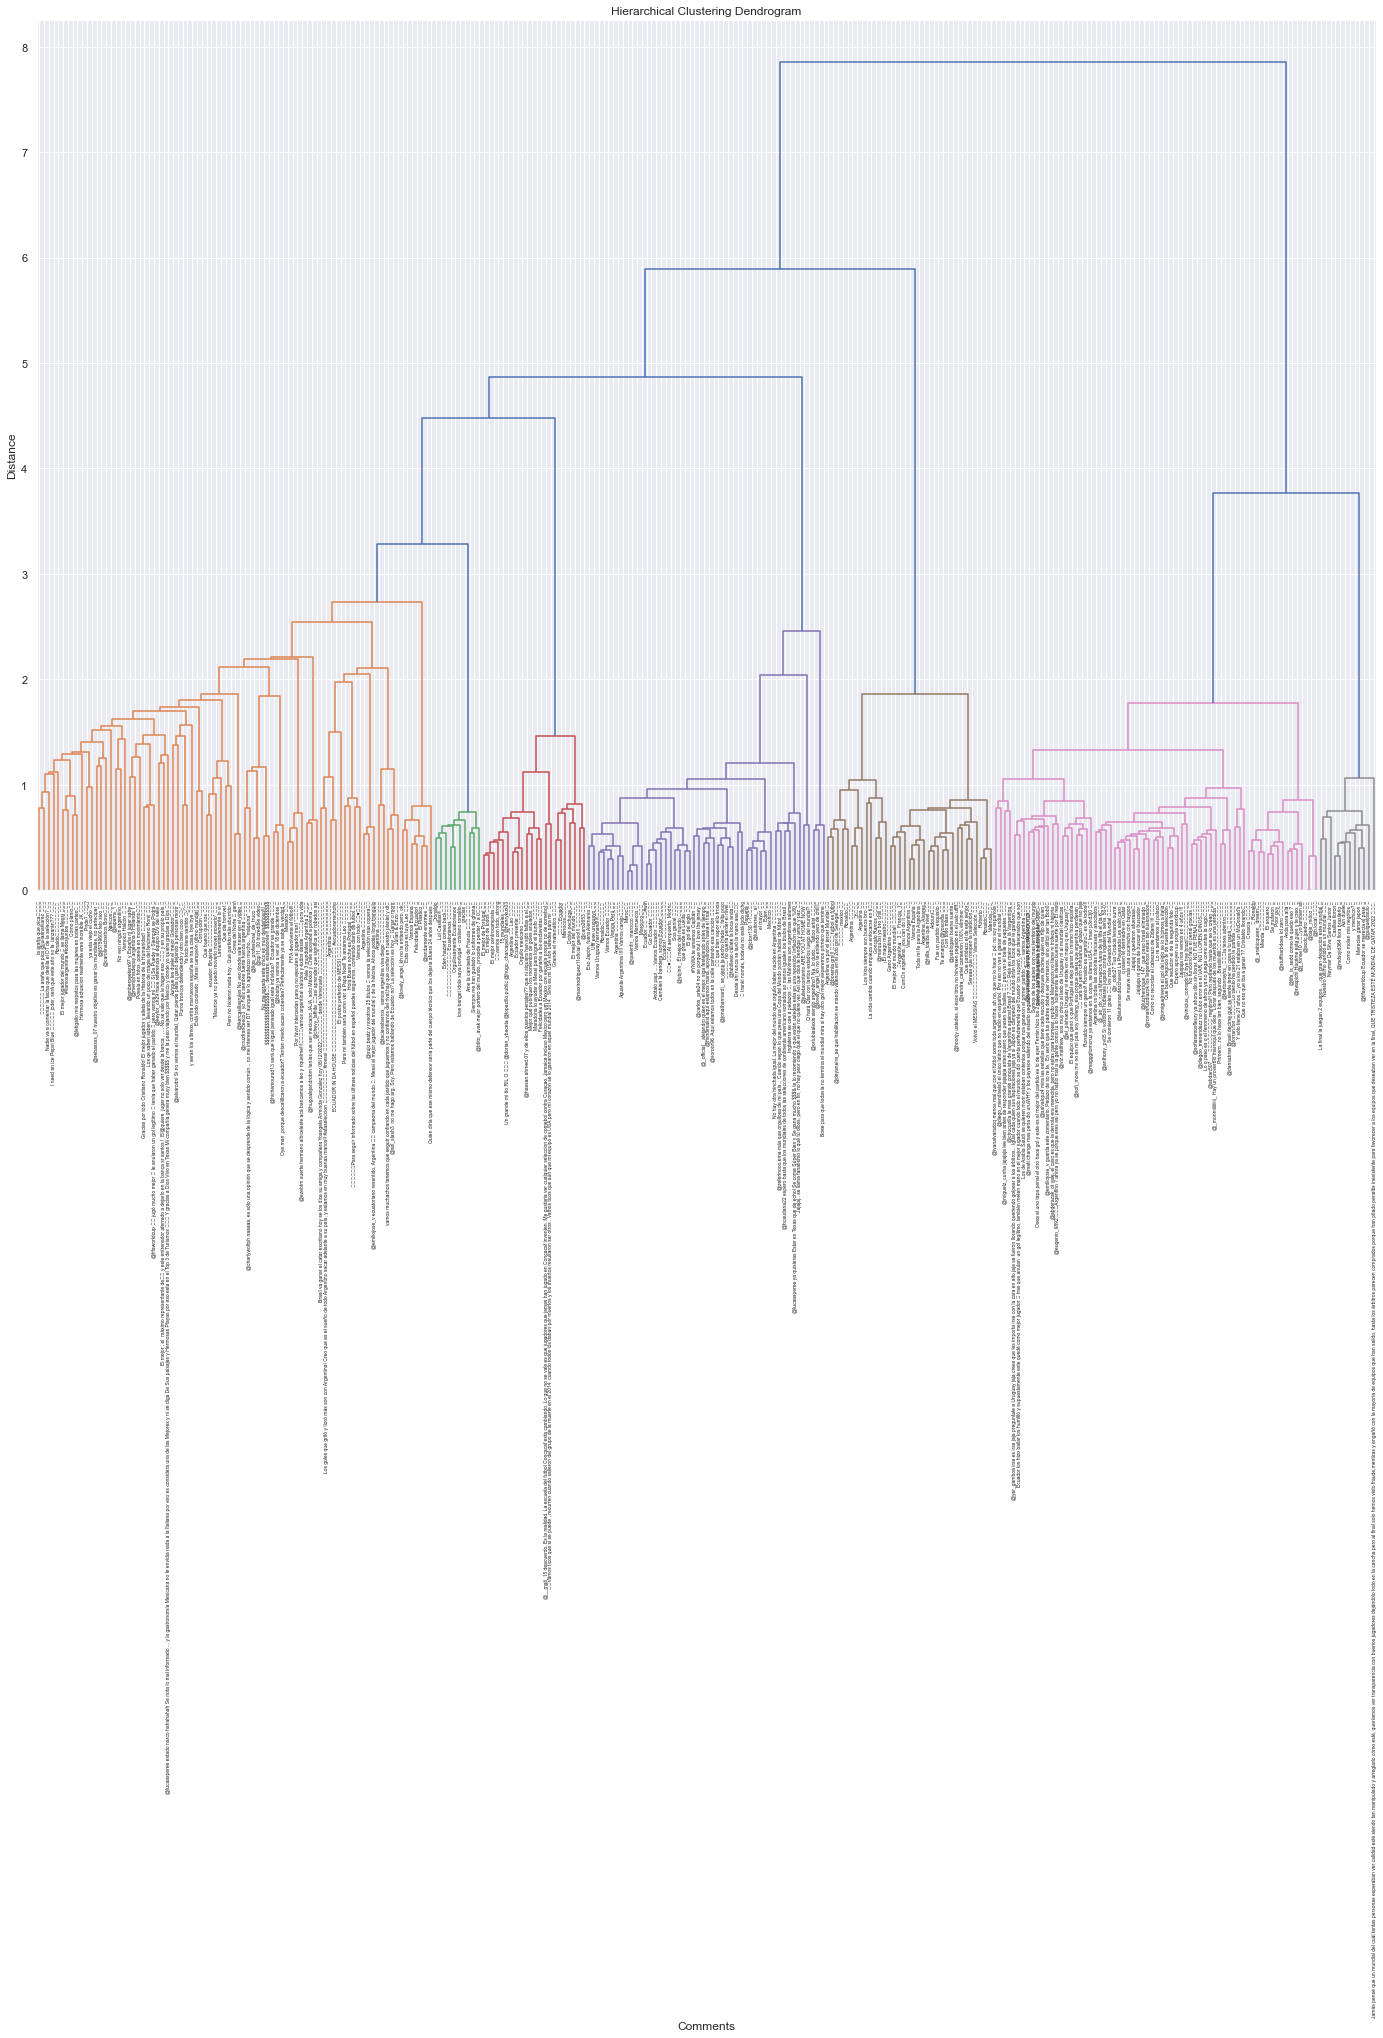

In [52]:
es_linkage_matrix, es_mean_silhouette, es_cluster_labels = apply_hierarchical_clustering(es_embeddings, es_df)

## Cluster Labels: 😢, 😂, 🔥, ❤️, 👏, 😍, Others

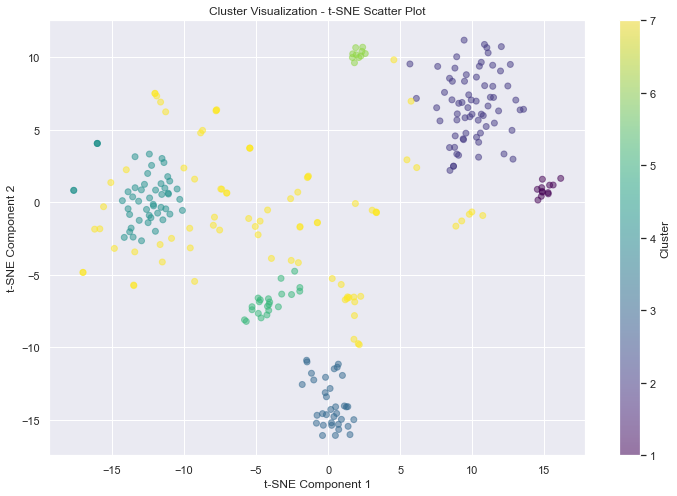

In [93]:
visualize_clusters_tsne(es_embeddings, es_cluster_labels)

In [57]:
es_linkage_matrix['translated_text'] = es_linkage_matrix['text'].apply(translate_text, target_language='en')

In [54]:
es_linkage_matrix

,text,cluster,silhouette_score,silhouette_score_mean
0,Orgullosamente Ecuatorianos 😍,6,0.502996,0.468130
1,❤️❤️❤️❤️❤️❤️ Ecuatorianos 😍😍😍😍😍,6,0.492119,0.468130
2,"@btito_.avak mejor portero del mundo, procede ...",6,0.443004,0.468130
3,Eden hazard comes back😍😍😍,6,0.480451,0.468130
4,love banget idola saya portugal - cristiano ro...,6,0.451412,0.468130
...,...,...,...,...
275,Neymar Da Silva Santos Junior 😢,1,0.380810,0.428671
276,@mdsojid364 llora brasileño 😢,1,0.489586,0.428671
277,Casillas lloron😢,1,0.487015,0.428671
278,Jamás pensé que un mundial del cuál tantas per...,1,0.259818,0.428671


In [55]:
es_mean_silhouette

,cluster,silhouette_score
0,1,0.428671
1,2,0.379912
2,3,0.388194
3,4,0.413665
4,5,0.394112
5,6,0.468130
6,7,-0.103273


In [31]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 6]['translated_text'].tolist()

['Proudly Ecuadorians 😍',
 '@Btito_.Avak Best goalkeeper in the world, proceeds to lose 7 to 0😍😍😍',
 'Eden hazard comes back😍😍😍',
 'I really love my idol Portugal - Cristiano Ronaldo.😍',
 "I have always liked Ghana's uniforms😍",
 'Love the France shirt 😍😍😍 🇺🇾🇨🇵',
 'Lol Casillas!!! 😍😍',
 'gracias 😍',
 '😍ronaldo',
 '❤️❤️❤️ located Ecuadorians 😍😍😍😍😍']

In [32]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 1]['translated_text'].tolist()

['@guiguelpaulo 😢',
 'How are my blacks shit 😢',
 '@fifaworldcup Ecuador deserved the pass 😢',
 'It still hurts',
 'and mechico? 😢',
 'I never thought that a World Cup from which so many people expected to see quality is being so manipulated and fixed how it is, we wantedOut, even the referees seem bought because they have been a non -existent penalty to favor the teams they wanted to see in the final, how sad is the world of Qatar 2022 😢😢😢.',
 'You deserved to win Japon 😢',
 'Neymar da Silva Santos Junior 😢',
 '@mdsojid364 cries Brazilian 😢',
 'Casillas Lloron😢',
 'Our last game in a World Cup 🇨🇴😢',
 'The final is played by 2 teams ...... What great disappointment this World Cup 😢']

In [33]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 4]['translated_text'].tolist()

['@_Ompoficial__Alejandro who is the best, continue to celebrate ahead of time 🤫',
 'the eldest 🤩🤩',
 'Ecuador 🇪🇨 ❤️#win',
 '@Luisitorres_ Yes 🥵',
 'That Japan, outside Germany ❤️',
 '@fabilleao Shock your mouth go',
 '@lucaasperee you would already want to be in Texas that Echol eats super good and you earn a lot $$$ & I recommend it and that you are in a recession/ inflation that %80 🥵',
 'Boee so that the World Cup is still not over if there is another better goal we hope first than end 🤙',
 'There is no other fans the same.The best in the world that proud to have been born in Argentina ❤️🇦🇷🇦🇷',
 'From there the hand was washed AAA❤️\u200d🩹',
 "Argentina feed !!!!!Let's fuck bla ining",
 'Morocco❤️',
 'England falls to pieces 🥱, the Malvinas are Argentinas Salames',
 'Ronaldo❤️❤️❤️',
 '@bcaudana22 I wait until the World Cups of all the American continent selections somados less equal to the titles of Brazil \U0001fae1',
 '@jonathanardi_ The friad chest is coming 🥶 little is missing'

In [61]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 5]['translated_text'].tolist()

['👏👏We go with everything, Strong',
 '👏👏🙌🙌Ecuador',
 'Congratulations to Ecuador for winning the slaves 👏🏼👏🏼',
 '15 World Cups 👏👏👏',
 'The best of all ❤️👏',
 "We are thicerly that if one can, they turn to when they left the death group in 2014 when they all gave them for dead and the dead turned out to be others.Let's go even if my team is USA but my heart won it in that 2014 World Cup.But it is my USA are you for me.❤️",
 'Ecuador present 🇪🇨👏👏',
 'Maradona help Messi to achieve triumph ❤️👏👏👏',
 'The best in the world 👏🏻 😍',
 'The best in Portugal 👏👏',
 'Mexican pride ❤️👏🏻🇲🇽',
 'Better publish the moments of canceled goals 👏👏',
 '@caro2653 👏👏👏',
 'Great the mathematician',
 'A great my uncle Ril or 👏👏👏 @dorian_ybaceta @lopezillo.public @hugo_charcape03 @hanrykux03',
 'The best midfielder 👏🏻',
 'Double breast 😂👏',
 '@Maxirodriguez11Oficial genius !!!👏👏👏👏💙🤍💙',
 "@__ mati_15 agreement.It's reality.The Concacaf Soccer School is changing.What is not worth is that players who have never play

In [62]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 3]['translated_text'].tolist()

['With every teacher 🔥🇨🇷',
 'Ronaldo🙌🔥',
 'The master magician🔥🔥🤍👏🏻⚡',
 'We love you @yosoy8a 🇲🇽🔥',
 "Let's go Spain 🔥",
 'Life changes when it begins to focus on you🎶🔥',
 '@sandra_cariel camereron 100% 🔥🔥',
 '@hoonjy you, if those shots did not get stuck in the Uffff stick🔥',
 'It will be to break the curse🔥🔥🔥',
 'Valencia🔥🔥🔥',
 'All my faith for Argentina 🔥',
 '@Borenia Grs !!!🔥🙌❤️ Soccer is football',
 '@pablogavi good luck🔥',
 '@deyaneira_ae to enable Valencia in the 2nd goal of Senegal🙌🔥🔥',
 "Messias returned 🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷 Let's go selection 🔥🔥🔥",
 'Ronaldo🔥🔥🔥🔥',
 'Aidoun 🔥❤️',
 '@hilla_loaiza what level 🔥🔥🔥',
 "What's up the one of this lord🔥",
 'Argentina 🔥💚',
 'The trios are always good bro 🔥😉',
 '@marqu3si yo bro chill 👏🔥',
 'The best in the world!❤️\u200d🔥❤️\u200d🔥',
 '😍ñ🔥🔥🔥',
 'Goncalo Ramos 🔥🔥👏👏',
 'CommOn argentina..you can do it 🔥❤️🔥',
 'Come on Argentina 🔥🔥',
 'It was an exquisite party 🔥',
 'Gano Argentina 🔥🔥🔥❤️❤️❤️',
 '🔥🔥🔥👏🙌 mexico 🇲🇽',
 'Argentina goes for the third Wo

In [64]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 7]['translated_text'].tolist()

["Let's go with everything 🇨🇷 ♥ ️⚽️",
 'Congratulations Ecuador!🙌',
 "@alvarodnl If we don't see the World Cup, Qatar loses money that won leaving people to die 🙃",
 'Corruption 💰💰💰💰',
 "@ikercasillasrules I don't see where Neuer comes out in the video 😮",
 'I need an Ice Pepsi Blue 😋😋😋😋😋 JODER, will it be that this year will not throw it ???🤔🤔🤔',
 "Let's go España 🙌",
 'The cucho is already old ☹☹',
 'But they did nothing today ... what a boring game 😒',
 "@bbsitaj we're going to see on December 18 😉",
 'Nobody is going to comment on the facade that distills the DT of the National Team?🌚😈',
 '@JL5759600 Telo Sico 🤫🤐',
 'VAMOOO HALCON 🦅 🇺🇾',
 'Hello good night is Portugal ⚽️👍🇵🇹',
 "@axl_sash3 I don't get arg.Am.But we are talking about Ecuador, right?The selection is today 💙 win or die.",
 '@Hichemourad13 Is this individual still thought about?Ecuador is great 🇪🇨😉😉',
 "@fifaWorldcup 🇪🇨 He played much better 😎 They canceled a legitimate goal 😠 I had to have won the game 👏 But let's go 🇪

# Both Embeddings

In [85]:
both_embeddings = np.concatenate((en_embeddings, es_embeddings))
both_df = pd.concat([en_df, es_df], axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


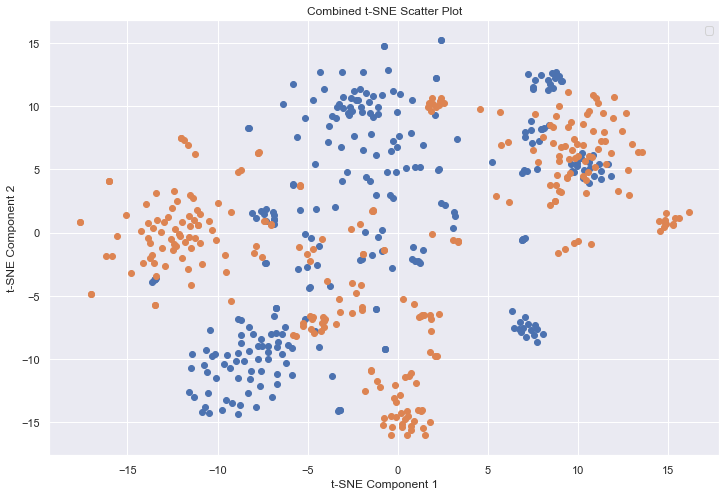

In [97]:
def visualize_combined_tsne(embeddings1, embeddings2, cluster_labels1, cluster_labels2):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings1_tsne = tsne.fit_transform(embeddings1)
    embeddings2_tsne = tsne.fit_transform(embeddings2)

    plt.figure(figsize=(12, 8))

    plt.scatter(embeddings1_tsne[:, 0], embeddings1_tsne[:, 1])
    plt.scatter(embeddings2_tsne[:, 0], embeddings2_tsne[:, 1])

    plt.title('Combined t-SNE Scatter Plot')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

visualize_combined_tsne(en_embeddings, es_embeddings, en_cluster_labels, es_cluster_labels)
